Объединенный датасет [FIX MEне доступен по ссылке](*).

Положить в папку data содержимое так, чтобы были следующие пути:  
* \$(ROOT_DIR)/data/full-rtsd/...
* \$(ROOT_DIR)/data/full-gt.csv

> *gt_Set_NaN.csv - содержит тот же датасет, но значения колонки Set обнулено*

gt - датафрейм содержащий:  
* имена файлов - поле filename
* класс знака - поле sign_class
* координаты знаков
* в какой набор включен знак - поле Set $\in$ $\{train, valid, test\}$  

### Init. If we're in Colab:
* Mount google drive to /content/drive/ to store model weights 

### Otherwise:
* save then in notebooks dir

In [1]:
import albumentations as A
if A.__version__ != '1.0.3':
    !pip install albumentations==1.0.3
    !pip install opencv-python-headless==4.5.2.52
    assert False, 'restart runtime pls'

import matplotlib.pyplot as plt

import numpy as np
import random
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import sys

%cd adas_system/notebooks

USE_COLAB_GPU = True
try:
    USE_TPU = bool(os.environ['COLAB_TPU_ADDR'])
except:
    USE_TPU = False

if USE_TPU:
    # !pip uninstall pytorch
    # !pip install cloud-tpu-client==0.10 torch==1.10.0
    # !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    import torch_xla
    import torch_xla.core.xla_model as xm
    USE_TPU = True

else:
    USE_TPU = False

IN_COLAB = False
import torch
from torch import nn

try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
    if not os.path.isfile('1.0.ClassifierResearch.ipynb'):
        print('already exist')
        !gdown --id 1-naWZnKN3okobAv9FNK-6K1cIzJM991P
        !git clone --branch 9_SignDetector https://github.com/lsd-maddrive/adas_system.git
        %cd adas_system/notebooks
        !unzip -q -o /content/USER_FULL_FRAMES.zip -d ./../data/

except:
    if IN_COLAB:
        print('LOOKS LIKE IN_COLAB = TRUE, but google drive not mounted. Check points sync wont work')
        !git clone --branch 9_SignDetector https://github.com/lsd-maddrive/adas_system.git
        !gdown --id 1-naWZnKN3okobAv9FNK-6K1cIzJM991P
        %cd adas_system/notebooks
        !unzip -q -o /content/USER_FULL_FRAMES.zip -d ./../data/
    else:
        USE_COLAB_GPU = False
    
###
import nt_helper
from nt_helper.helper_utils import *
###

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
%matplotlib inline
plt.rcParams["figure.figsize"] = (17,10)

if USE_TPU:
    device = xm.xla_device()
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print("IN COLAB or USE_COLAB GPU =", IN_COLAB or USE_COLAB_GPU)

[WinError 3] The system cannot find the path specified: 'adas_system/notebooks'
D:\d_tsw\1_SIGN_CLASSIFIER\notebooks
helper init success
cuda
IN COLAB or USE_COLAB GPU = False


## Init dirs

In [2]:
if not IN_COLAB:
    PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
else:
    PROJECT_ROOT = pathlib.Path('..')
    
DATA_DIR = PROJECT_ROOT / 'data'
NOTEBOOKS_DIR = PROJECT_ROOT / 'notebooks'

if (NOTEBOOKS_DIR / 'full-gt.csv').is_file():
    full_gt = pd.read_csv(NOTEBOOKS_DIR / 'full-gt.csv')
else:
    full_gt = pd.read_csv(DATA_DIR / 'full-gt.csv')

FORMATED_GT_PATH = DATA_DIR / "USER_FULL_FRAMES.csv"
FULL_GT_SRC_LEN = len(full_gt.index)

## Init dataset DataFrame

In [3]:
if os.path.isfile(FORMATED_GT_PATH):
    print("FORMATED GT EXIST. LOAD IT")
    
    import ast
    
    formated_full_gt_df = pd.read_csv(FORMATED_GT_PATH, dtype=object)
    formated_full_gt_df['coords'].replace({'\n ':',', ' \s+': ' ', '\[ ': '['}, regex=True, inplace=True)
    
    formated_full_gt_df['coords'] = formated_full_gt_df['coords'].apply(
        lambda x: ast.literal_eval(x)
    )
    
    formated_full_gt_df['size'] = formated_full_gt_df['size'].apply(
        lambda x: ast.literal_eval(x)
    )

    formated_full_gt_df['filepath'] = formated_full_gt_df['filepath'].apply(
        lambda x: str(DATA_DIR / x.replace('\\', '/'))
    )
else:
    print("FORMATED GT DOESNT EXIST. CREATE IT")
    
    # get all original filenames
    full_gt_unique_filenames = set(full_gt['filename'])
    full_gt_unique_filenames_size = len(full_gt_unique_filenames)
    
    formated_full_gt_list = []

    import imagesize
    i = 0
    for src_filename_iterator in list(full_gt_unique_filenames):

        mask = np.in1d(full_gt['filename'], [src_filename_iterator])
        coord_data_arr = full_gt[mask][['x_from', 'y_from', 'width', 'height']].to_numpy()
        
        filepath = DATA_DIR / "USER_FULL_FRAMES" / src_filename_iterator
        origW, origH = imagesize.get(filepath)
                
        rel_coord = []
        for coord in coord_data_arr:
            # make from x, y, dx, dx -> x1, y1, x2, y2
            CV2RectangleCoords = ConvertAbsTLWH2CV2Rectangle(coord)
   
            # make from x1, y1, x2, y2 -> x, y, w, h
            CV2CircleCoords = ConvertCV2Rectangle2CenterXYWH(CV2RectangleCoords)
            
            # make x, y, w, h -> relative x, y, w, h
            rel_instance = MakeRel(CV2CircleCoords, origW, origH)
            rel_coord.append(rel_instance)
            
        if i % 100 == 0:
            printProgressEnum(i, full_gt_unique_filenames_size)
        i += 1

        formated_full_gt_list.append([str(filepath), rel_coord, [origW, origH]])

    formated_full_gt_df = pd.DataFrame(formated_full_gt_list, columns=['filepath', 'coords', 'size'])
    formated_full_gt_df.to_csv(FORMATED_GT_PATH, index=False)

if 'set' in formated_full_gt_df.columns:
    print('SET ALREADY EXIST')
else:
    print('SET DOESNT EXIST. LETS CREATE IT')
    formated_full_gt_df_index_count = len(formated_full_gt_df.index)
    TRAIN_SIZE = round(0.7 * formated_full_gt_df_index_count)
    VALID_SIZE = round(0.2 * formated_full_gt_df_index_count)
    TEST_SIZE = round(formated_full_gt_df_index_count - TRAIN_SIZE - VALID_SIZE)
        
    assert TRAIN_SIZE + VALID_SIZE + TEST_SIZE == formated_full_gt_df_index_count, 'wrong split'
    set_series = pd.Series('test', index=range(TEST_SIZE)).append(
        pd.Series('train', index=range(TRAIN_SIZE)).append(
            pd.Series('valid', index=range(VALID_SIZE))
        )
    ).sample(frac=1).reset_index(drop=True)
    formated_full_gt_df['set'] = set_series
    formated_full_gt_df.to_csv(FORMATED_GT_PATH, index=False)
    
display(formated_full_gt_df.head())

FORMATED GT EXIST. LOAD IT
SET ALREADY EXIST


,filepath,coords,size,set
0,..\data\USER_FULL_FRAMES\autosave01_02_2012_09...,"[[0.6671875, 0.49722222222222223, 0.01484375, ...","[1280, 720]",train
1,..\data\USER_FULL_FRAMES\autosave16_10_2012_08...,"[[0.56015625, 0.4666666666666667, 0.01640625, ...","[1280, 720]",train
2,..\data\USER_FULL_FRAMES\autosave24_10_2012_11...,"[[0.9, 0.11805555555555555, 0.05546875, 0.0930...","[1280, 720]",test
3,..\data\USER_FULL_FRAMES\autosave10_10_2012_08...,"[[0.57421875, 0.48194444444444445, 0.0609375, ...","[1280, 720]",train
4,..\data\USER_FULL_FRAMES\autosave16_10_2012_10...,"[[0.78046875, 0.2777777777777778, 0.02421875, ...","[1280, 720]",train


# simple test

..\data\USER_FULL_FRAMES\autosave24_10_2012_11_08_03_1.jpg
Shape: 1280 720
+ [0.83125, 0.3611111111111111, 0.86640625, 0.425]
xywh [1087, 283, 45, 46]
x1y1x2y2 [1064, 260, 1109, 306]


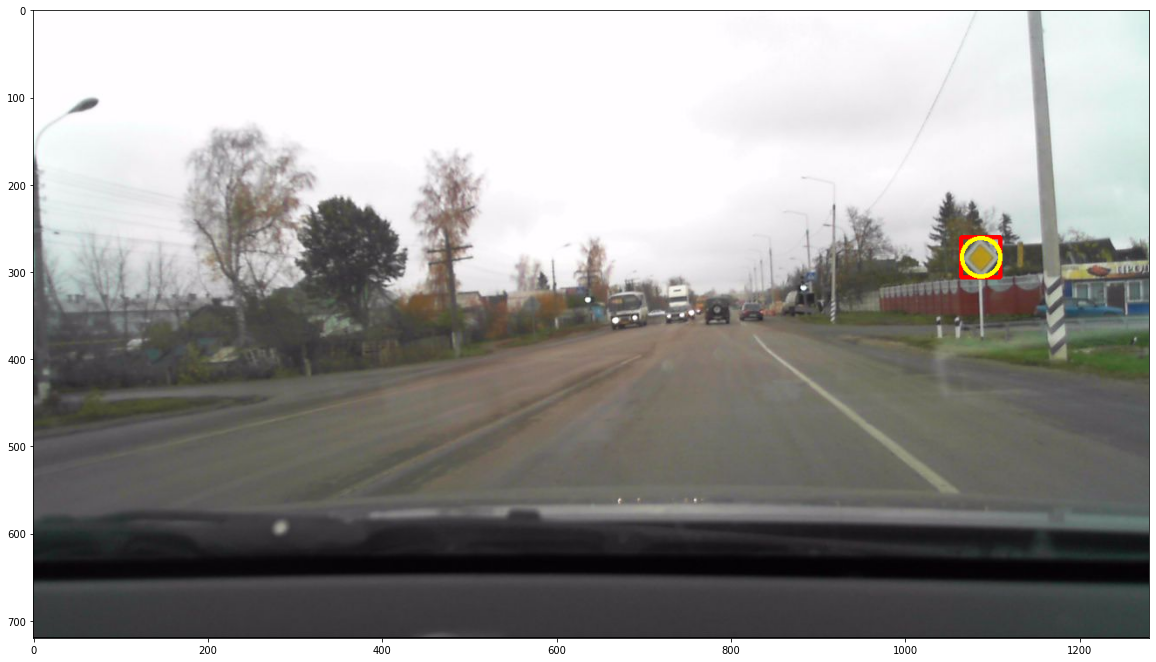

In [4]:
instance = formated_full_gt_df.iloc[15466]

path_ = str(instance['filepath'])
print(path_)
img = cv2.imread(path_)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

h, w = img.shape[0], img.shape[1]
print('Shape:', w, h)

for i in instance['coords']:
    
    xywh = UnmakeRel(i, w, h)
    x1y1x2y2 = ConvertCenterXYWH2CV2Rectangle(xywh)
    print('+', MakeRel(x1y1x2y2, w, h))
    print('xywh', xywh)
    print('x1y1x2y2', x1y1x2y2)
    
    
    img = cv2.rectangle(img, (x1y1x2y2[0], x1y1x2y2[1]), 
                        (x1y1x2y2[2], x1y1x2y2[3]), 
                        (255, 0, 0), 
                        3)
    
    img = cv2.circle(img, 
                     (xywh[0], xywh[1]), 
                     xywh[2] // 2, 
                     (255, 255, 0), 
                     3)

plt.figure(figsize = (20, 20))  
plt.imshow(img)
plt.show()

# Now we have pd.DataFrame that contains filenames, list of relative coordinates, corresponding photo resoulutions and marks for set. 
## createDataLoaderAndDataSet function in utils.ipynb

albumentations: Blur(always_apply=False, p=0.01, blur_limit=(3, 7)), MedianBlur(always_apply=False, p=0.01, blur_limit=(3, 7)), ToGray(always_apply=False, p=0.01), CLAHE(always_apply=False, p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
albumentations: Blur(always_apply=False, p=0.01, blur_limit=(3, 7)), MedianBlur(always_apply=False, p=0.01, blur_limit=(3, 7)), ToGray(always_apply=False, p=0.01), CLAHE(always_apply=False, p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


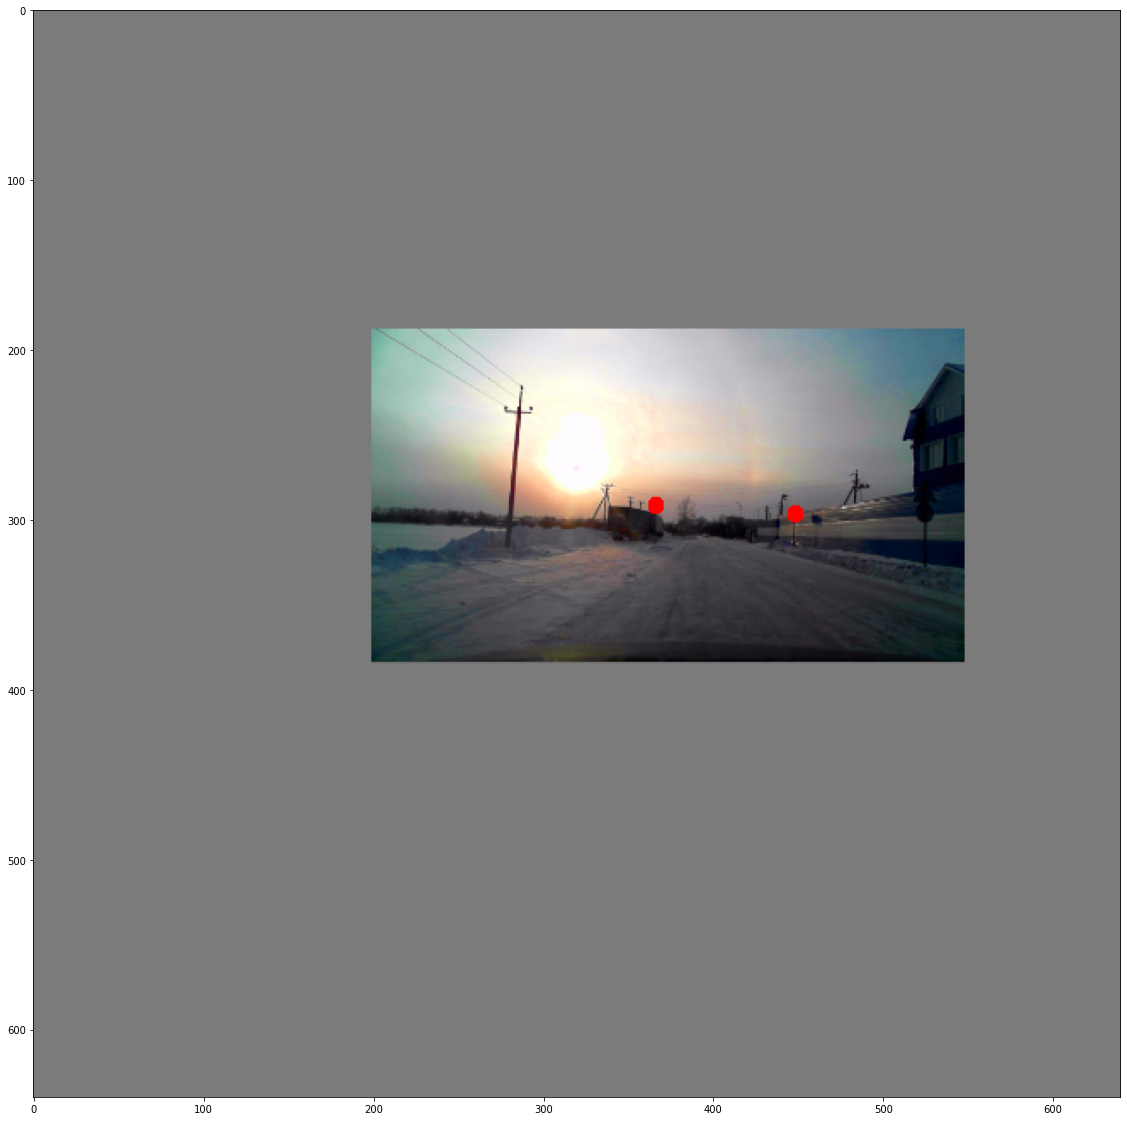

In [7]:
import yaml

hyps_file = DATA_DIR / "hyp.scratch.yaml"
with open(hyps_file, errors='ignore') as f:
    hyp = yaml.safe_load(f)


IMG_SIZE = 640
batch_size = 1
train_loader, train_dataset = createDataLoaderAndDataSet(formated_full_gt_df, 
                                                         'train',
                                                         hyp_arg=hyp,
                                                         imgsz=IMG_SIZE, 
                                                         batch_size=batch_size, 
                                                         augment=True)

test_loader, test_dataset = createDataLoaderAndDataSet(formated_full_gt_df, 
                                                         'test',
                                                         hyp_arg=hyp,
                                                         imgsz=IMG_SIZE, 
                                                         batch_size=batch_size, 
                                                         augment=True)

del test_loader, train_loader, test_dataset

img, labels_out, filepath, shapes = train_dataset[98]
# img_, labels_out_, filepath_, shapes_ = test_dataset[random.randrange(0, len(test_dataset))]

imgNT = img.numpy().transpose(1, 2, 0).astype(np.uint8).copy() #, cv2.COLOR_BGR2RGB)
# print(labels_out)
# print(filepath)
for coord in labels_out[:, 2:]:
    # print(coord)
    h, w = shapes[0]
    xywh = UnmakeRel(coord, IMG_SIZE, IMG_SIZE)
    x1y1x2y2 = ConvertCenterXYWH2CV2Rectangle(xywh)
    # print(x1y1x2y2)
    imgNT = cv2.rectangle(imgNT, (x1y1x2y2[0], x1y1x2y2[1]), 
                        (x1y1x2y2[2], x1y1x2y2[3]), 
                        (255, 0, 0), 
                        3)


plt.figure(figsize = (20, 20))  
plt.imshow(imgNT)
plt.show()

<b>ROAD SIGN ANCHORS:</b> 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326 [Source](https://grechka.family/dmitry/blog/2019/09/yolo-v3-anchors-for-traffic-sign-detection/)

In [ ]:
assert False, 'restart'

# Train?

In [ ]:
from torch.optim import SGD, lr_scheduler
from torch.cuda import amp
from utils.general import one_cycle, LOGGER
from utils.loss import ComputeLoss
from utils.torch_utils import ModelEMA, de_parallel
from tqdm import tqdm
from datetime import datetime
from models.yolo import Model

import yaml

hyps_file = DATA_DIR / "hyp.scratch.yaml"
with open(hyps_file, errors='ignore') as f:
    hyp = yaml.safe_load(f)


def train(epochs, model, train_loader, valid_loader, device, opt=None, imgsz=640):
       
    ###
    start_epoch = 0
    nc = 1
    model.float()
    # print(device.type)
    cuda = device.type == 'cuda'
    # print(cuda)
    nb = len(train_loader)
    nw = max(round(hyp['warmup_epochs'] * nb), 1000)
    nbs = 64  # nominal batch size
    batch_size = train_loader.batch_size
    last_opt_step = -1
    ###
        
    g0, g1, g2 = [], [], []  # optimizer parameter groups
    for v in model.modules():
        if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):  # bias
            g2.append(v.bias)
        if isinstance(v, nn.BatchNorm2d):  # weight (no decay)
            g0.append(v.weight)
        elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):  # weight (with decay)
            g1.append(v.weight)
    
    optimizer = SGD(g0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
    
    optimizer.add_param_group({'params': g1, 'weight_decay': hyp['weight_decay']})  # add g1 with weight_decay
    optimizer.add_param_group({'params': g2})  # add g2 (biases)
    del g0, g1, g2
    

    lf = one_cycle(1, hyp['lrf'], epochs)  # cosine 1->hyp['lrf']
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    
    ema = ModelEMA(model)
    
    nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
    hyp['box'] *= 3 / nl  # scale to layers
    hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
    hyp['obj'] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
    hyp['label_smoothing'] = opt.label_smoothing if opt else 0.
    
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.names = ['sign']
    
    scaler = amp.GradScaler(enabled=cuda)
    compute_loss = ComputeLoss(model)
    
    for epoch in range(start_epoch, epochs):
        model.train()
        mloss = torch.zeros(3, device=device)
        
        pbar = enumerate(train_loader)
        LOGGER.info(('\n' + '%10s' * 7) % ('Epoch', 'gpu_mem', 'box', 'obj', 'cls', 'labels', 'img_size'))
        pbar = tqdm(pbar, total=nb, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
        
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0
            
            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # compute_loss.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

            # Forward
            with amp.autocast(enabled=cuda):
                pred = model(imgs)  # forward
                loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
                
            # Backward
            scaler.scale(loss).backward()

            # Optimize
            if ni - last_opt_step >= accumulate:
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)
                last_opt_step = ni
            
            if True:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
                pbar.set_description(('%10s' * 2 + '%10.4g' * 5) % (
                    f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
        
        ###
        # every 5 epochs check mAP
        if False and (epoch + 1) % 5 == 0:
            ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
            map = valid_epoch()

        ###

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
        scheduler.step()
                
        now = datetime.now()
        model_save_name = DATA_DIR / 'YoloV5_{}_lbox{:.4f}_lobj{:.4f}.pt'.format(
            now.strftime("%d.%m_%H.%M"),
            mloss[0], mloss[1]
        )
        
        torch.save(model.state_dict(), model_save_name)

        try:
            from google.colab import files
            files.download(model_save_name)
        except:
            pass

        if IN_COLAB:
            shutil.copy2(model_save_name, '/content/drive/MyDrive/')

    
    print('TRAIN END')
    return 1




num_workers = 0
if IN_COLAB or USE_COLAB_GPU:
    num_workers = 2

LARGE = True

if LARGE:
    restore= DATA_DIR / 'YoloV5L.pt'
    model_cfg_file = DATA_DIR / 'yolov5l_custom_anchors.yaml'
    IMG_SIZE = 416
    batch_size = 2
    if IN_COLAB or USE_COLAB_GPU:
        batch_size = 60

else:
    restore= DATA_DIR / 'YoloV5S.pt'
    model_cfg_file = DATA_DIR / 'yolov5s_custom_anchors.yaml' 
    IMG_SIZE = 640  
    batch_size = 2
    if IN_COLAB or USE_COLAB_GPU:
        batch_size = 80

train_loader, train_dataset = createDataLoaderAndDataSet(formated_full_gt_df, 
                                                         'train',
                                                         hyp_arg=hyp,
                                                         imgsz=IMG_SIZE, 
                                                         batch_size=batch_size, 
                                                         augment=True,
                                                         nw=num_workers)

valid_loader, valid_dataset = createDataLoaderAndDataSet(formated_full_gt_df, 
                                                         'valid',
                                                         hyp_arg=hyp,
                                                         imgsz=IMG_SIZE, 
                                                         batch_size=batch_size * 3, 
                                                         augment=False,
                                                         nw=num_workers)
SHOULD_I_TRAIN = True
IN_COLAB = True

model = Model(cfg=model_cfg_file, ch=3, nc=1)
model.load_state_dict(torch.load(restore, map_location=device))
hyp['lr0'] = 0.001
model.hyp = hyp  # attach hyperparameters to model
model.to(device)

if SHOULD_I_TRAIN:
    pass
    
else:
    pass

model.info()

In [ ]:
hyp['lr0']

In [ ]:
model = train(32, model, train_loader, valid_loader, device, imgsz=IMG_SIZE)

In [ ]:
from utils.metrics import ConfusionMatrix, ap_per_class
from utils.general import (
    box_iou, check_dataset, check_img_size, check_requirements, check_yaml,
    increment_path, non_max_suppression, print_args,
    scale_coords, xywh2xyxy, xyxy2xywh
    )

def process_batch(detections, labels, iouv):
    """
    Return correct predictions matrix. Both sets of boxes are in (x1, y1, x2, y2) format.
    Arguments:
        detections (Array[N, 6]), x1, y1, x2, y2, conf, class
        labels (Array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (Array[N, 10]), for 10 IoU levels
    """
    correct = torch.zeros(detections.shape[0], iouv.shape[0], dtype=torch.bool, device=iouv.device)
    iou = box_iou(labels[:, 1:], detections[:, :4])
    x = torch.where((iou >= iouv[0]) & (labels[:, 0:1] == detections[:, 5]))  # IoU above threshold and classes match
    if x[0].shape[0]:
        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().detach().numpy()  # [label, detection, iou]
        if x[0].shape[0] > 1:
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            # matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        matches = torch.Tensor(matches).to(iouv.device)
        correct[matches[:, 1].long()] = matches[:, 2:3] >= iouv
    return correct

@torch.no_grad()
def valid_epoch(model, dataloader, imgsz=640, iou_thres=0.5, conf_thres=0.01, nc=1, compute_loss=None, half=True):

    model.eval()
    map = 0
    
    single_cls = True if nc==1 else False

    device, pt, jit, engine = next(model.parameters()).device, True, False, False  # get model device, PyTorch model

    half &= device.type != 'cpu'  # half precision only supported on CUDA
    model.half() if half else model.float()

    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    names = {k: v for k, v in enumerate(model.names if hasattr(model, 'names') else model.module.names)}

    s = ('%20s' + '%11s' * 6) % ('Class', 'Images', 'Labels', 'P', 'R', 'mAP@.5', 'mAP@.5:.95')
    dt, p, r, f1, mp, mr, map50, map = [0.0, 0.0, 0.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class = [], [], [], []
    pbar = tqdm(dataloader, total=len(dataloader), desc=s, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    for batch_i, (im, targets, paths, shapes) in enumerate(pbar):

        im = im.to(device) #, non_blocking=True)
        targets = targets.to(device)
        
        im = im.half() if half else im.float()
        im /= 255
        nb, _, height, width = im.shape

        # Inference
        out, train_out = model(im)
        if compute_loss:
            loss += compute_loss([x.float() for x in train_out], targets)[1]  # box, obj, cls

        # NMS
        targets[:, 2:] *= torch.Tensor([width, height, width, height]).to(device)  # to pixels
        lb = []  # for autolabelling
        out = non_max_suppression(out, conf_thres, iou_thres, labels=lb, multi_label=True, agnostic=single_cls)
        
        # Metrics
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            shape = shapes[si][0]
            seen += 1
            
            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Predictions
            if single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_coords(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_coords(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
            else:
                correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))  # (correct, conf, pcls, tcls)
        
        torch.cuda.empty_cache()
    
    # Compute metrics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    # print(*stats)
    # print(stats)
    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=False, save_dir='.', names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)

    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]

    pf = '%20s' + '%11i' * 2 + '%11.3g' * 4  # print format
    LOGGER.info(pf % ('all', seen, nt.sum(), mp, mr, map50, map))
    return (mp, mr, map50, map, *(loss.cpu() / len(dataloader)).tolist()), maps

res = valid_epoch(model, valid_loader, imgsz=640, compute_loss=ComputeLoss(model))
print(res)

In [ ]:
model.names

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
valid_loader.batch_size

In [ ]:
detectInterface = makeDetectFromModel(model)
detectInterface.eval()
detectInterface.to(device)
print('!')

In [ ]:
detectInterface.model[-1]

In [ ]:
def valid(model, val_loader):
    
    ###
    nc = 1
    
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.names = ['sign']
    
    detectInterface = makeDetectFromModel(model)
    ###
    s = ('%20s' + '%11s' * 6) % ('Class', 'Images', 'Labels', 'P', 'R', 'mAP@.5', 'mAP@.5:.95')
    pbar = tqdm(enumerate(val_loader), desc=s, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    compute_loss = ComputeLoss(model)
    
    loss = torch.zeros(3, device=device)
    # print(1)
    for batch_i, (im, targets, paths, shapes) in pbar:
        # print(2)
        im = im.to(device, non_blocking=True).float()
        im /= 255
        
        nb, _, height, width = im.shape  # batch size, channels, height, width

        
        out, train_out = model(im)
        # print('out', out)
        print(train_out)
        print(targets)
        _ = [x.float() for x in train_out]
        for i in range(3):
            print(_[i].shape)
        loss += compute_loss([x.float() for x in train_out], targets)[1]  # box, obj, cls
        
       
    
valid(model, valid_loader)    

In [ ]:
train_out

In [ ]:
IN_COLAB

In [ ]:
os.cpu_count()

# TEST MODEL

In [ ]:
import random
from datetime import datetime
now = datetime.now

restore='YoloV5Last.pt'
model_cfg_file = 'yolov5s_custom_anchors.yaml'

import logging
logger = logging.getLogger()
model = Model(cfg=model_cfg_file, ch=3, nc=1);
model.load_state_dict(torch.load(restore, map_location=device))

detectInterface = makeDetectFromModel(model)

In [ ]:
from utils.datasets import LoadImages
img_, labels_out_, filepath_, shapes_ = test_dataset[155] # random.randrange(0, len(test_dataset))]

img_size = 640
dataset = LoadImages(filepath_, img_size=img_size, auto=False)
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

device = 'cuda'

imgsz = (img_size, img_size)

detectInterface.warmup(imgsz=(1, 3, imgsz))
detectInterface.to(device)

for path, im, im0s, vid_cap, s in dataset:
    
    #print(im.shape)
    #print(im0s)
    im0s_orig = im0s
    im = torch.from_numpy(im).float()
    im /= 255
    im = im[None, ...]
    im = im.to(device)
    t0 = now()
    
    pred = detectInterface(im)
    print('process dT =', now() - t0)
    data = detectInterface.translatePreds(pred, im.shape[2:], im0s.shape, conf_thres=0.05)
    
    
    
    im0s = cv2.cvtColor(im0s, cv2.COLOR_BGR2RGB)
    for i in range(data['count']):
        im0s = cv2.rectangle(im0s, (data['coords'][i][0], data['coords'][i][1]), 
                        (data['coords'][i][2], data['coords'][i][3]), 
                        (255, 0, 0), 
                        3)
        
        im0s = cv2.putText(im0s, str(round(data['confs'][i], 3)), 
                           (data['coords'][i][2] - 40, data['coords'][i][3]),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.7, (255, 255, 0),
                           5, cv2.LINE_AA
                          )
        
        im0s = cv2.putText(im0s, str(round(data['confs'][i], 3)), 
                           (data['coords'][i][2] - 40, data['coords'][i][3]),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.7, (0, 0, 0),
                           2, cv2.LINE_AA
                          )
        
        

    print('plot dT =', now() - t0)
    
fig, axs = plt.subplots(2, figsize=(20, 20))
axs[0].imshow(im0s)

im0s_orig = cv2.cvtColor(im0s_orig, cv2.COLOR_BGR2RGB)
axs[1].imshow(im0s_orig)